In [1]:
import pandas as pd, numpy as np, scipy, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

# Global Variables

In [2]:
filename = 'Cape Expected Return.xlsx'
def addOne(df, column):
    df[column] = df[column] + 1
def makeReal(df):
    df.Return = df.Return - inflation.Inflation

# Read Data

In [3]:
# Inflation
inflation = pd.read_excel(filename, sheet_name = 'Inflation')
inflation['Inflation2'] = inflation.Inflation
addOne(inflation, 'Inflation2')

# Stock
stock = pd.read_excel(filename, sheet_name = 'Stock')
addOne(stock, 'Return')
makeReal(stock)
stock['percentage'] = (1.1922/stock.Cape - 0.0139) * 0.7
# stock['percentage'] = (0.5/stock.Cape + 0.01) * 1

# Bond
bond = pd.read_excel(filename, sheet_name = 'Bond')
addOne(bond, 'Return')
makeReal(bond)
bond['percentage'] = (np.log(bond.Yield) * 0.0386 + 0.1354) * 0.8

# Saving for Retirement

<AxesSubplot:xlabel='Start'>

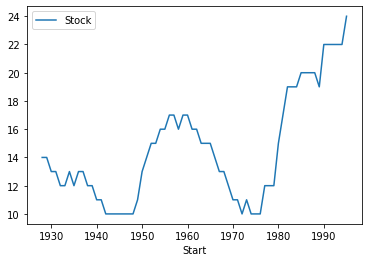

In [4]:
def getYears(allocation, i, verbose = False):
    mix = pd.DataFrame({
        'Return': allocation * stock.Return + (1-allocation) * bond.Return, 
        'percentage': allocation * stock.percentage + (1-allocation) * bond.percentage
    })
    mix.index = stock.Start
    total = 0
    # Get Dollar Cost Average Return for gap years
    for j, r in enumerate(mix.loc[i:i+gap].itertuples()):
        total = (total + 1) * r.Return
        if verbose:
            print(r[0], total, r.Return, r.percentage, total * r.percentage)
        if total * r.percentage > 1:
            break
    return j+1

def getYearsHelper(allocation):
    output = []
    # Mix Stocks and Bonds According to Allocation
    for i in stock.Start[:len(stock)-gap]:
        output.append(getYears(allocation, i))
    return output
gap = 24
save = pd.DataFrame({
    'Stock': getYearsHelper(1), 
#     'Mixed': getYearsHelper(0.5), 
#     'Bond': getSave(0)
}, index = stock[:-gap].Start)
save.plot()

<AxesSubplot:xlabel='Start'>

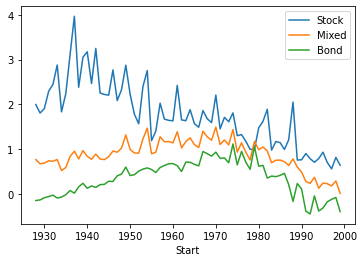

In [5]:
def getSave(allocation):
    output = []
    # Mix Stocks and Bonds According to Allocation
    mix = pd.DataFrame({
        'Return': allocation * stock.Return + (1-allocation) * bond.Return, 
        'percentage': allocation * stock.percentage + (1-allocation) * bond.percentage
    })
    for i in range(len(mix)-gap):
        total = 0
        # Get Dollar Cost Average Return for gap years
        for r in mix[i:i+gap].itertuples():
            total = (total + 1) * r.Return
        # Get Final Spending Amount
        output.append(total * mix.percentage[i+gap])
    return output
gap = 20
save = pd.DataFrame({
    'Stock': getSave(1), 
    'Mixed': getSave(0.5), 
    'Bond': getSave(0)
}, index = stock[:-gap].Start)
save.plot()

# Spending During Retirement

<ipython-input-6-f285833643e5>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


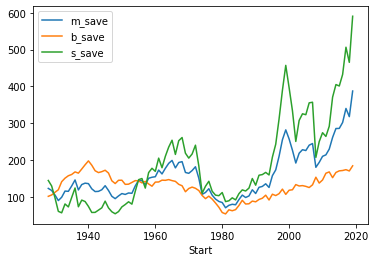

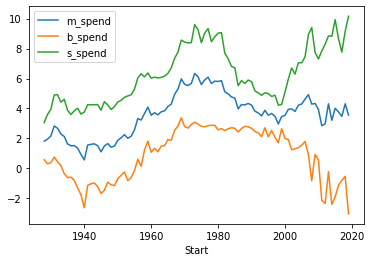

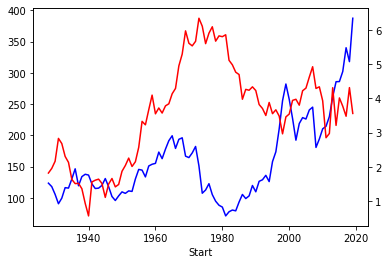

In [6]:
def getSpend(df, prefix):
    output, save, spend = [], 100, 0
    
    # Update saving and spending each year
    for r in df.itertuples():
        save = (save - spend) * r.Return
        spend = save * r.percentage
        output.append([save, spend])
    output = pd.DataFrame(output, columns = ['%s_save' % prefix, '%s_spend' % prefix])
    return output

# Make Tables for stocks and bonds
spend = pd.concat([getSpend(stock, 's'), getSpend(bond, 'b')], axis=1)
spend.index = stock.Start

# Mix Stocks and Bonds according to allocation
ratio = 0.5
for name in 'save', 'spend':
    spend['m_'+name] = ratio * spend['s_'+name] + (1-ratio) * spend['b_'+name]

# Plot Saving and Spending
columns = lambda name: [letter+'_'+name for letter in 'mbs']
spend[columns('save')].plot()
spend[columns('spend')].plot()

# Plot Saving and Spending Together
letter = 'm'
fig, ax1 = plt.subplots()
spend[letter+'_save'].plot(ax=ax1, style = 'b-')
ax2 = ax1.twinx()
spend[letter+'_spend'].plot(ax=ax2, style = 'r-')
fig.show()

# Valuation vs Expected Return

In [7]:
getLog = lambda x, a, b: a * np.log(x) + b
getInverse = lambda x, a, b: a * (1/x) + b
getLinear = lambda x, a, b: a * x + b

def getRSquared(df, function, column):
    # Generate coefficients for regression
    x, y = df[column], df.actual
    (a, b), pcov = curve_fit(function, x, y)
    # Get Predictions
    predicted = function(x, a, b)
    # Get Residuals
    residuals = y - predicted
    # Get Residual Sum of Squares
    ss_res = np.sum(residuals ** 2)
    # Get Total Sum of Squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # Get R Squared
    rSquared = 1 - (ss_res / ss_tot)
    return rSquared, predicted, a, b

def getScatter(df, column):
    ax1 = df.plot(kind='scatter', x=column, y='actual', color='r')    
    ax2 = df.plot(kind='scatter', x=column, y='predicted', color='g', ax=ax1)  

def getYearN(n, plot, table, column, function, real = True):
    # Prepare Data
    asset = pd.read_excel(filename, sheet_name = table)
    addOne(asset, 'Return')
    # Real/Nominal Returns
    if real:
        makeReal(asset)
    # Must come after Real, so that index matches inflation's index
    asset = asset.set_index('Start')
    
    # Get Average return for next n years
    output = []
    inflation2 = []
    limit = len(asset)-n
    for i in range(limit):
        # Geometric mean for i+1 to i+n+1 years
        output.append(asset.Return[i+1:i+n+1].product() ** (1/n) - 1)
        inflation2.append(inflation.Inflation2[i+1:i+n+1].product() ** (1/n) - 1)
    asset = asset[0:limit]
    asset['actual'] = output
    asset['inflation'] = inflation2

    # Get Regression Line and Plot
    rSquared, asset['predicted'], a, b = getRSquared(asset, function, column)
    asset['difference'] = asset.actual - asset.predicted
    if plot:
        getScatter(asset, column)
        fig, ax1 = plt.subplots()
        asset.difference.plot(ax=ax1, style = 'b-')
        ax2 = ax1.twinx()
        asset.actual.plot(ax=ax2, style = 'r-')
        asset.predicted.plot(ax=ax2, style = 'g-')        
        fig.show()
    return rSquared, a, b, asset

printRound = lambda list_: [x.round(4) for x in list_[:-1]]

def getValuation(middle, table, column, function, real = True):
    for i in range(middle-10, middle+10):
        print(i, printRound(getYearN(i, False, table, column, function, real)))
    prediction = getYearN(middle, True, table, column, function, real)
    print(printRound(prediction))
    return prediction[-1]

# Stocks

9 [0.2944, 1.2536, -0.0159]
10 [0.3324, 1.2708, -0.0174]
11 [0.3953, 1.3486, -0.0232]
12 [0.4493, 1.3745, -0.0254]
13 [0.4909, 1.3822, -0.0259]
14 [0.5317, 1.3682, -0.0249]
15 [0.5558, 1.3247, -0.022]
16 [0.5729, 1.2707, -0.0184]
17 [0.6068, 1.2568, -0.0177]
18 [0.6379, 1.2369, -0.0168]
19 [0.6428, 1.1922, -0.0139]
20 [0.6299, 1.1193, -0.0088]
21 [0.6024, 1.0358, -0.0029]
22 [0.5973, 0.9831, 0.0008]
23 [0.5787, 0.9229, 0.0049]
24 [0.5443, 0.8411, 0.0105]
25 [0.4825, 0.7288, 0.0183]
26 [0.4255, 0.6185, 0.0261]
27 [0.3647, 0.5213, 0.0328]
28 [0.3238, 0.4493, 0.0376]
[0.6428, 1.1922, -0.0139]


<ipython-input-7-b6544fcfd5d0>:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


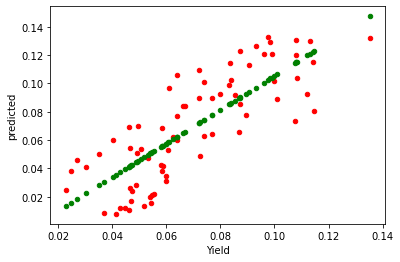

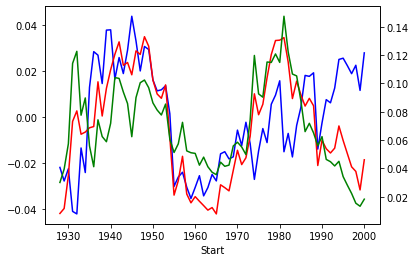

In [8]:
stockPrediction = getValuation(19, 'Stock', 'Yield', getLinear, True)

# Bonds

20 [0.8144, 0.044, 0.1497]
21 [0.8372, 0.0434, 0.1482]
22 [0.8575, 0.0427, 0.1461]
23 [0.8839, 0.0424, 0.1453]
24 [0.9033, 0.0419, 0.144]
25 [0.9175, 0.0411, 0.1418]
26 [0.9393, 0.0408, 0.1412]
27 [0.9583, 0.0405, 0.1403]
28 [0.9639, 0.0398, 0.1385]
29 [0.9687, 0.0391, 0.1367]
30 [0.9729, 0.0386, 0.1354]
31 [0.9678, 0.038, 0.1338]
32 [0.9597, 0.0373, 0.1321]
33 [0.9487, 0.0368, 0.1306]
34 [0.9333, 0.036, 0.1285]
35 [0.9128, 0.0353, 0.1266]
36 [0.8847, 0.0347, 0.125]
37 [0.8551, 0.0341, 0.1236]
38 [0.8217, 0.0334, 0.1214]
39 [0.7978, 0.0336, 0.1227]
[0.9729, 0.0386, 0.1354]


<ipython-input-7-b6544fcfd5d0>:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


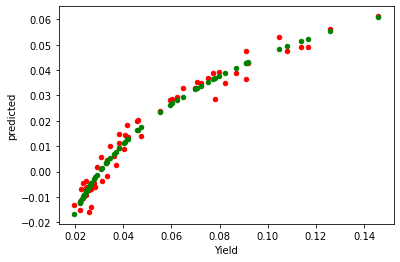

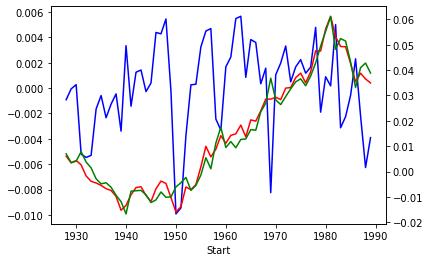

In [9]:
bondPrediction = getValuation(30, 'Bond', 'Yield', getLog, real = True)

# Get Year N Regression

<AxesSubplot:xlabel='cape'>

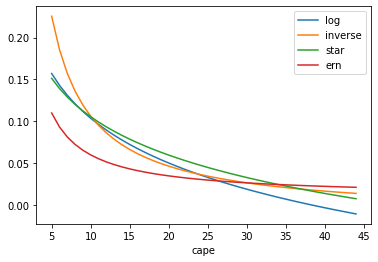

In [10]:
a = pd.DataFrame({'cape': range(5, 45)})
a['log'] = np.log(a.cape) * -0.077 + 0.281
a['inverse'] = 1.192/a.cape - 0.013
a['star'] = np.log(a.cape) * -0.066 + 0.2575
a['ern'] = 0.5 / a.cape + 0.01
a['ern'] = 0.5 / a.cape + 0.01
a.set_index('cape')[['log', 'inverse', 'star', 'ern']].plot()

<AxesSubplot:xlabel='yield_'>

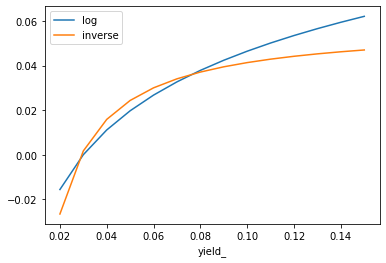

In [11]:
a = pd.DataFrame({'yield_': range(2, 16)})
a.yield_ = a.yield_ / 100
a['log'] = (np.log(a.yield_) * 0.0386 + 0.1354)
a['inverse'] = (-0.0017/a.yield_ + 0.0584)
a.set_index('yield_')[['log', 'inverse']].plot()

# Write Out

In [12]:
writer = pd.ExcelWriter('Cape Expected Return 2.xlsx')
save.to_excel(writer, 'save')
spend.to_excel(writer, 'spend')
stockPrediction.to_excel(writer, 'stock')
bondPrediction.to_excel(writer, 'bond')
writer.save()